In [1]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.optimizers import SGD, Adadelta
from keras.layers import Input, Flatten, Dense, Dropout
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import keras
from keras import backend as K


cifar10 = tf.keras.datasets.cifar10
epoch_range = 500

Using TensorFlow backend.


In [2]:
def compressed_weights(model):
    model_weights = np.array(model.get_weights())
    #print(DNN_weights)
    comp = []
    for i in range(len(model_weights)):
        model_weights[i] = model_weights[i].reshape(len(model_weights[i]),-1)
        model_weights[i] = model_weights[i].flatten()
        model_weights[i] = model_weights[i].reshape(len(model_weights[i]),-1)
        #print(model_weights[i].shape)
        for j in range(len(model_weights[i])):
            comp.append(model_weights[i][j])
    comp = np.array(comp).flatten()
    return comp
    

In [3]:
def get_gradients_norm(model, inputs, outputs):
    #from https://stackoverflow.com/questions/51140950/how-to-obtain-the-gradients-in-keras
    """ Gets gradient of model for given inputs and outputs for all weights"""
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    grad_sum = 0
    for i in range(len(output_grad)):
        grad_sum += np.sum(output_grad[i])**2
    grad_norm = grad_sum ** 0.5
    return grad_norm


In [4]:
class MY_SHALLOW1(object):
    def __init__(self, width = 32, height = 32, channels = 3):
        self.width = width
        self.height = height
        self.channels = channels
        
        self.shape = (self.width, self.height, self.channels)
        self.optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-8, nesterov=False)
        
        self.model = self.__model()
        self.model.compile(loss='categorical_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        
    def __model(self):
        inputs = Input(shape = self.shape)
        x = Flatten(input_shape = self.shape)(inputs)
        x = Dense((self.width * self.height * self.channels + 502), activation='relu')(x)
        y = Dropout(0.2)(x)
        outputs = Dense(10,activation='softmax')(y)
        model = Model(inputs=inputs, outputs=outputs)
        model.summary()
        
        return model
        
    def train(self, x_train, y_train, epochs = 500, batch = 256, collect_interval = 3):
        loss = []
        accuracy = []
        weights = []
        grads = []
        
        for cnt in range(epochs):
            history = self.model.fit(x_train, y_train, batch_size=batch, verbose = 0)
            print("epoch:%d ,loss:%s, accuracy:%s "%(cnt, history.history['loss'], history.history['acc']))
            loss.append(history.history['loss'])
            accuracy.append(history.history['acc'])
            grads.append(get_gradients_norm(self.model, x_train, y_train))
            
            if(cnt%collect_interval == 0):
                w = compressed_weights(self.model)
                weights.append(w)
            
        self.loss = loss
        self.accuracy = accuracy
        self.weights = weights
        self.grads = grads
                

In [5]:
if __name__ == '__main__':
    if tf.test.gpu_device_name():
        print('GPU found')
    else:
        print("No GPU found")
    
    (x_train, y_train),(x_test, y_test) = cifar10.load_data()
    #normalization for not getting to big output for 'relu' and other activation
    x_train = x_train/255
    x_test = x_test/255
    y_train = np_utils.to_categorical(y_train, num_classes=10)
    y_test = np_utils.to_categorical(y_test, num_classes=10)
 
    #for dense layer, the parameters = (input_shape + 1) * size;
    
    

GPU found


In [6]:
    
    SHALLOW1 = MY_SHALLOW1()
    SHALLOW1.train(x_train, y_train)
    SHALLOW1.model.save("CIFAR10_SHALLOW1.h5")
    np.save('CIFAR10_SHALLOW1_LOSS', SHALLOW1.loss)
    np.save('CIFAR10_SHALLOW1_ACC', SHALLOW1.accuracy)
    np.save('CIFAR10_SHALLOW1_WEIGHTS',SHALLOW1.weights)
    np.save('CIFAR10_SHALLOW1_GRADS',SHALLOW1.grads)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3574)              10982902  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3574)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                35750     
Total params: 11,018,652
Trainable params: 11,018,652
Non-trainable params: 0
_________________________________________________________________
epoch:0 ,loss:[1.8579853451156616], accuracy:[0.34297999999046325] 
epoch:1 ,loss:[1.6606602630233764], accuracy:[0.41934000000953

epoch:111 ,loss:[0.39082928274154666], accuracy:[0.87244] 
epoch:112 ,loss:[0.3896199566459656], accuracy:[0.8714599999809265] 
epoch:113 ,loss:[0.38145782545089724], accuracy:[0.8745599999809265] 
epoch:114 ,loss:[0.3720467846107483], accuracy:[0.877860000038147] 
epoch:115 ,loss:[0.36578614844322205], accuracy:[0.879159999961853] 
epoch:116 ,loss:[0.3572991089630127], accuracy:[0.883019999961853] 
epoch:117 ,loss:[0.35540366550445557], accuracy:[0.8830000000381469] 
epoch:118 ,loss:[0.36151905371665954], accuracy:[0.8824600000190734] 
epoch:119 ,loss:[0.35195638518333433], accuracy:[0.88414] 
epoch:120 ,loss:[0.34430728889465334], accuracy:[0.887240000038147] 
epoch:121 ,loss:[0.3501180652236939], accuracy:[0.8834200000190735] 
epoch:122 ,loss:[0.3378368639469147], accuracy:[0.890280000038147] 
epoch:123 ,loss:[0.33553441957473756], accuracy:[0.8891400000190735] 
epoch:124 ,loss:[0.3398439623260498], accuracy:[0.8887799999809265] 
epoch:125 ,loss:[0.31814697027206423], accuracy:[0.89

epoch:233 ,loss:[0.10106608382701873], accuracy:[0.9716999999618531] 
epoch:234 ,loss:[0.10448230026245117], accuracy:[0.9709200000190735] 
epoch:235 ,loss:[0.09541525479078293], accuracy:[0.9743600000381469] 
epoch:236 ,loss:[0.10304769603729248], accuracy:[0.972340000038147] 
epoch:237 ,loss:[0.10310423787593842], accuracy:[0.971959999961853] 
epoch:238 ,loss:[0.09889883447647095], accuracy:[0.9726999999809265] 
epoch:239 ,loss:[0.10705321570396423], accuracy:[0.969619999961853] 
epoch:240 ,loss:[0.09623785434722901], accuracy:[0.97312] 
epoch:241 ,loss:[0.09539577666282653], accuracy:[0.97428] 
epoch:242 ,loss:[0.09787082710504531], accuracy:[0.972320000038147] 
epoch:243 ,loss:[0.0922098225069046], accuracy:[0.975720000038147] 
epoch:244 ,loss:[0.08516512487649917], accuracy:[0.977740000038147] 
epoch:245 ,loss:[0.0824695300400257], accuracy:[0.97886] 
epoch:246 ,loss:[0.09370286769390106], accuracy:[0.9740200000381469] 
epoch:247 ,loss:[0.0893435328912735], accuracy:[0.97672000001

epoch:356 ,loss:[0.044758530483841895], accuracy:[0.9897] 
epoch:357 ,loss:[0.046919782351255414], accuracy:[0.98898] 
epoch:358 ,loss:[0.047171728026270864], accuracy:[0.98892] 
epoch:359 ,loss:[0.0486461950135231], accuracy:[0.9879800000190735] 
epoch:360 ,loss:[0.050363511208295825], accuracy:[0.98718] 
epoch:361 ,loss:[0.04250029459416866], accuracy:[0.9900800000190735] 
epoch:362 ,loss:[0.04350017528176308], accuracy:[0.9898000000190735] 
epoch:363 ,loss:[0.045186510536670686], accuracy:[0.9892] 
epoch:364 ,loss:[0.042212630367279055], accuracy:[0.9907600000190735] 
epoch:365 ,loss:[0.041284537180662155], accuracy:[0.9903800000190734] 
epoch:366 ,loss:[0.04292721296489239], accuracy:[0.99038] 
epoch:367 ,loss:[0.0426930087685585], accuracy:[0.989940000038147] 
epoch:368 ,loss:[0.043543814606666564], accuracy:[0.9902200000190735] 
epoch:369 ,loss:[0.04644904801487923], accuracy:[0.988320000038147] 
epoch:370 ,loss:[0.04558197172641754], accuracy:[0.9887800000190735] 
epoch:371 ,los

epoch:483 ,loss:[0.029267741793990134], accuracy:[0.99332] 
epoch:484 ,loss:[0.026044502890110018], accuracy:[0.9946600000190735] 
epoch:485 ,loss:[0.02841383312702179], accuracy:[0.993920000038147] 
epoch:486 ,loss:[0.026004097199440003], accuracy:[0.9946] 
epoch:487 ,loss:[0.025518742436766623], accuracy:[0.99494] 
epoch:488 ,loss:[0.026251634417176248], accuracy:[0.99476] 
epoch:489 ,loss:[0.02503746041506529], accuracy:[0.99506] 
epoch:490 ,loss:[0.023712643528580664], accuracy:[0.9953000000190735] 
epoch:491 ,loss:[0.024863990072011947], accuracy:[0.99472] 
epoch:492 ,loss:[0.02551874210715294], accuracy:[0.9944600000190735] 
epoch:493 ,loss:[0.028703583023548127], accuracy:[0.993880000038147] 
epoch:494 ,loss:[0.02342487105846405], accuracy:[0.99542] 
epoch:495 ,loss:[0.02405662803709507], accuracy:[0.99522] 
epoch:496 ,loss:[0.02557748506784439], accuracy:[0.99442] 
epoch:497 ,loss:[0.02772511367738247], accuracy:[0.9939] 
epoch:498 ,loss:[0.029640926971435548], accuracy:[0.9929

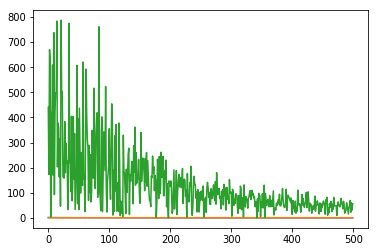

In [8]:
    
    plt.plot(range(epoch_range), SHALLOW1.loss)
    plt.plot(range(epoch_range), SHALLOW1.accuracy)
    plt.plot(range(epoch_range), SHALLOW1.grads)
